## Importing necessary libraries

In [ ]:
# importing necessary libraries and versions
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import time

# Pandas for overview
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt

# importing PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

# importing requests library to get the data from url
import requests

## Loading the dataset from website

In [ ]:
# loading the pre-processed dataset from the given URL
url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes_scale"
response = requests.get(url)
data = response.text.split('\n')

# Initialize an empty Pandas DataFrame with column names
column_names = ['Label'] + [f'Feature_{i}' for i in range(1, 9)]
diabetes_df = pd.DataFrame(columns=column_names)

# Iterate through the input data and directly append rows to the DataFrame
for line in data:
    columns = line.strip().split(' ')
    row = [columns[0]]  # The first column is the target label (-1 or +1)

    # Extract the feature-value pairs and add them to the row
    for i in range(1, 9):
        feature_value = columns[i].split(':') if len(columns) > i else ['0', '0']  # Handle missing values by using '0'
        row.append(float(feature_value[1]) if len(feature_value) == 2 else np.nan)

    # Append the row to the DataFrame
    diabetes_df.loc[len(diabetes_df)] = row

# Impute missing values (replace NaN with the mean of the respective column)
diabetes_df = diabetes_df.fillna(diabetes_df.mean())

# As evident, the last row has every entry as zero, so we can remove that by sicing in pandas library
diabetes_df = diabetes_df[:-1]
# Save the DataFrame as a CSV file
# df.to_csv('output.csv', index=False)

# Display the DataFrame (optional)
print(diabetes_df)

    Label  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0      -1  -0.294118   0.487437   0.180328  -0.292929  -1.000000   0.001490   
1      +1  -0.882353  -0.145729   0.081967  -0.414141  -1.000000  -0.207153   
2      -1  -0.058824   0.839196   0.049180  -1.000000  -1.000000  -0.305514   
3      +1  -0.882353  -0.105528   0.081967  -0.535354  -0.777778  -0.162444   
4      -1  -1.000000   0.376884  -0.344262  -0.292929  -0.602837   0.284650   
..    ...        ...        ...        ...        ...        ...        ...   
763    +1   0.176471   0.015075   0.245902  -0.030303  -0.574468  -0.019374   
764    +1  -0.764706   0.226131   0.147541  -0.454545  -1.000000   0.096870   
765    +1  -0.411765   0.216080   0.180328  -0.535354  -0.735225  -0.219076   
766    -1  -0.882353   0.266332  -0.016393  -1.000000  -1.000000  -0.102832   
767    +1  -0.882353  -0.065327   0.147541  -0.373737  -1.000000  -0.093890   

     Feature_7  Feature_8  
0    -0.531170  -0.0333

<ipython-input-2-df60aa8eb102>:24: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  diabetes_df = diabetes_df.fillna(diabetes_df.mean())


The data already seems to be normalised and scaled. Additionally, the missing entries in rows have been replaced by the mean of the respective columns by imputation. Most of the pre-processing required before pre-processing has been done. Let's plot the response variable on a bar graph to see its distribution on the entire dataset before making training and testing splits.

## Basic visualisations

array([[<Axes: title={'center': 'Feature_1'}>,
        <Axes: title={'center': 'Feature_2'}>,
        <Axes: title={'center': 'Feature_3'}>],
       [<Axes: title={'center': 'Feature_4'}>,
        <Axes: title={'center': 'Feature_5'}>,
        <Axes: title={'center': 'Feature_6'}>],
       [<Axes: title={'center': 'Feature_7'}>,
        <Axes: title={'center': 'Feature_8'}>, <Axes: >]], dtype=object)

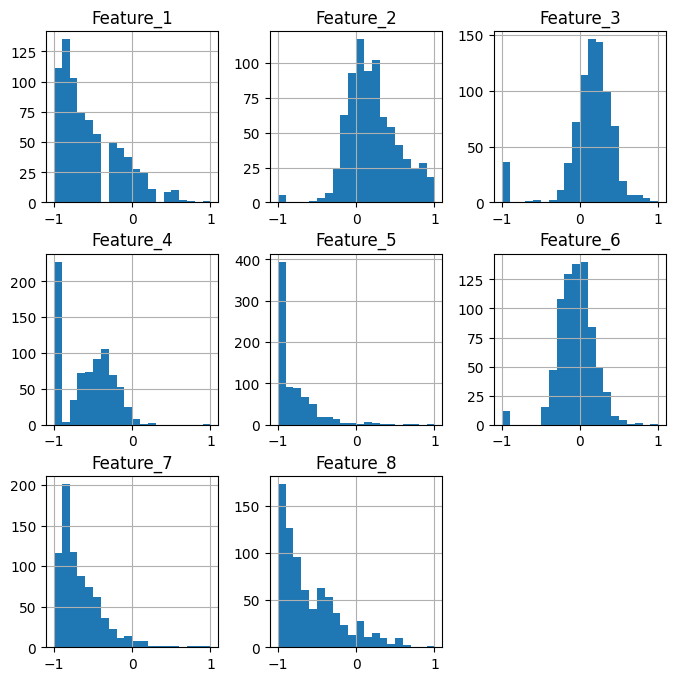

In [ ]:
# getting histograms of each of the features
diabetes_df.hist(bins = 20, figsize = (8,8))

## Disproportionate label sizes for the response variable

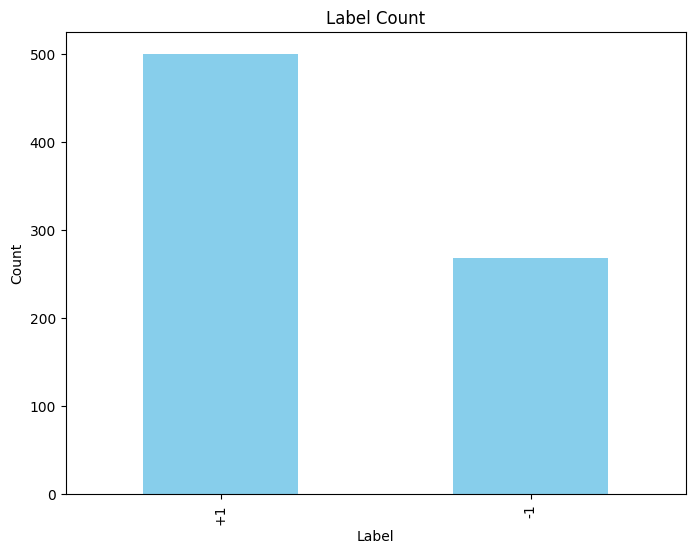

+1    500
-1    268
Name: Label, dtype: int64


In [ ]:
# Count the occurrences of each label value
label_counts = diabetes_df['Label'].value_counts()

# Create a bar graph
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Count')
plt.xlabel('Label')
plt.ylabel('Count')

# Display the bar graph
plt.show()

# Also, printing the counts of each label
print(label_counts)

Now, it is quite clear from the above graph the data is quite imbalanced in terms of the distribution of the response variable. The number of diabetic patients in this dataset is almost double that of non-diabetic patients. This means we will need to stratify the data before splitting.

## Splitting the data set

In [ ]:
from sklearn.model_selection import train_test_split

# Convert labels to integers in the DataFrame
diabetes_df['Label'] = diabetes_df['Label'].astype(int)

# Assuming your DataFrame is named 'diabetes_df' and the label column is named 'Label'
X = diabetes_df.drop(columns=['Label'])  # Features (all columns except 'Label')
y = diabetes_df['Label']  # Target variable

# converting features and labels to numpy arrays
X = X.to_numpy()
y = y.to_numpy().reshape(y.shape[0],1)

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42,   # setting the seed for reproducibility
                                                    stratify = y)  # stratification ensures that the class distribution is similar in both the training and test sets

print("Number of rows in the training set:", X_train.shape[0])
print("Number of rows in the test set:", X_test.shape[0])

Number of rows in the training set: 614
Number of rows in the test set: 154


In [ ]:
# Now I want to further split the training data into actual train and validation sets.

X_actual_train, X_validation, y_actual_train, y_validation = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify = y_train)

print("Number of rows in the actual training set:", X_actual_train.shape[0])
print("Number of rows in the validation set:", X_validation.shape[0])
print("Number of rows in the test set:", X_test.shape[0])

Number of rows in the actual training set: 491
Number of rows in the validation set: 123
Number of rows in the test set: 154


## Changing labels from -1, 1 to 0, 1 form

In [ ]:
# Convert y labels to 0 and 1 format
print("Unique labels before conversion:", np.unique(y_actual_train))
y_actual_train[y_actual_train == -1] = 0
y_validation[y_validation == -1] = 0
y_test[y_test == -1] = 0
print("Unique labels after conversion:", np.unique(y_actual_train))
# print(y_actual_train)

Unique labels before conversion: [-1  1]
Unique labels after conversion: [0 1]


## Checking the data for linear separability

In [ ]:
# SVM is used as an indicator to see of the data given to us is linearly separable or not
from sklearn.svm import SVC
# Create an SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Fit the SVM model to the training data
svm_model.fit(X_train, y_train)

# Make predictions on the training data
y_pred_train_svm = svm_model.predict(X_train)

# Calculate accuracy on the training data
accuracy_train_svm = np.mean(y_pred_train_svm == y_train)
print("Accuracy of SVM on Training Set:", accuracy_train_svm)

Accuracy of SVM on Training Set: 0.5749928381202983


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Generating Perceptron class

In [ ]:
class Perceptron:
    def __init__(self, loss_function="perceptron", learning_rate=0.1, bias=0.0, n_epochs=1000, initial_weight_seed=None):
        self.loss_function = loss_function  # Loss function ("perceptron" or "zero_one" for Zero-One loss)
        self.learning_rate = learning_rate  # Learning rate for weight updates
        self.bias = bias  # Initial bias
        self.n_epochs = n_epochs  # Number of training epochs
        self.initial_weight_seed = initial_weight_seed  # Seed for initializing weights (None for random)

        self.weights = None
        self.seed = None

        # Lists to store loss and accuracy values at each epoch
        self.loss_history = []
        self.accuracy_history = []
        self.trainingLosses = []
        self.validationLosses = []
        self.trainingAccuracies = []
        self.validationAccuracies = []

    def fit(self, X, y, X_val=None, y_val=None):
        n_samples, n_features = X.shape
        self.seed = self.initial_weight_seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.weights = np.random.rand(n_features) if self.seed is None else np.random.RandomState(self.seed).rand(n_features)

        for epoch in range(self.n_epochs):
            total_loss = 0
            correct_predictions = 0

            for i in range(n_samples):
                y_pred = self.predict(X[i])
                update = self.learning_rate * (y[i] - y_pred)
                self.weights += update * X[i]
                self.bias += update

                total_loss += self.calculate_loss(y[i], y_pred)
                correct_predictions += 1 if y[i] == y_pred else 0

            average_loss = total_loss / n_samples
            accuracy = correct_predictions / n_samples

            self.loss_history.append(average_loss)
            self.accuracy_history.append(accuracy)

            # Store training losses and accuracies
            self.trainingLosses.append(average_loss)
            self.trainingAccuracies.append(accuracy)

            if X_val is not None and y_val is not None:
                val_loss = 0
                correct_val_predictions = 0
                for i in range(len(X_val)):
                    val_pred = self.predict(X_val[i])
                    val_loss += self.calculate_loss(y_val[i], val_pred)
                    correct_val_predictions += 1 if y_val[i] == val_pred else 0

                average_val_loss = val_loss / len(X_val)
                val_accuracy = correct_val_predictions / len(X_val)

                self.validationLosses.append(average_val_loss)
                self.validationAccuracies.append(val_accuracy)

    def predict(self, x):
        linear_output = np.dot(x, self.weights) + self.bias
        if self.loss_function == "perceptron":
            return 1 if linear_output > 0 else 0
        elif self.loss_function == "zero_one":
            return 1 if linear_output >= 0 else 0

    def calculate_loss(self, true_label, predicted_label):
        if self.loss_function == "perceptron":
            losses = -true_label * (np.dot(self.weights, predicted_label) + self.bias)
            return np.maximum(0, losses)
        elif self.loss_function == "zero_one":
            return np.where(true_label != predicted_label, 1, 0)

    def plot_loss_and_accuracy_curves(self):
        epochs = range(1, self.n_epochs + 1)

        plt.figure(figsize=(12, 5))

        # Plot loss curve
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.loss_history, label="Training Loss", marker='o')
        plt.title("Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot accuracy curve
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.accuracy_history, label="Training Accuracy", marker='o')
        plt.title("Accuracy Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
print("X_actual_train shape:", X_actual_train.shape)
print("y_actual_train shape:", y_actual_train.shape)
print("Unique labels in y_actual_train:", np.unique(y_actual_train))

X_actual_train shape: (491, 8)
y_actual_train shape: (491, 1)
Unique labels in y_actual_train: [0 1]


### Baseline Perceptron

Accuracy of Baseline Model on Validation Set: 0.5843743803291691


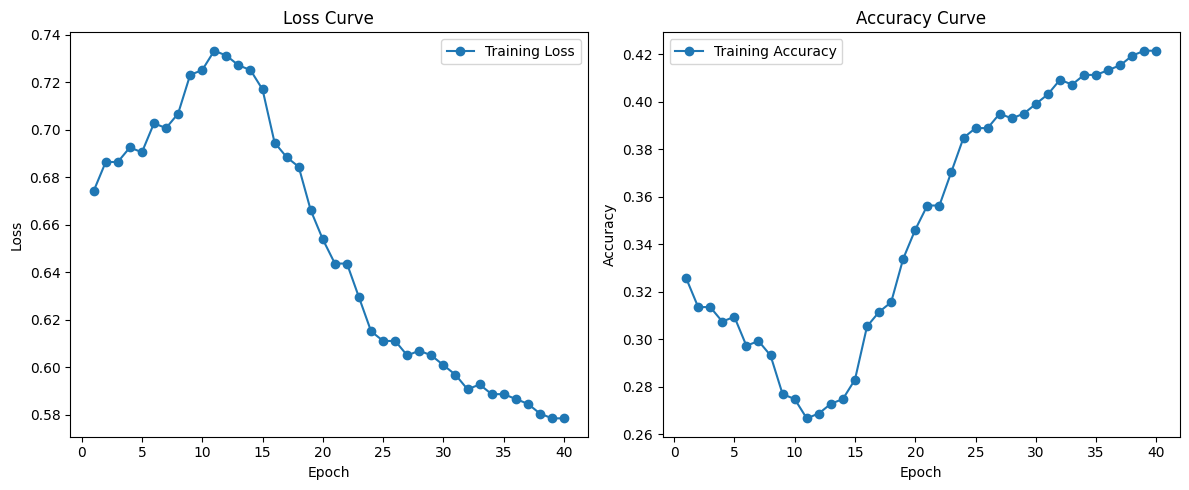

In [ ]:
# Create a Perceptron model for the baseline
baseline_perceptron = Perceptron(
    loss_function="zero_one",  # Use Zero-One Loss
    learning_rate=0.0001,      # Learning rate of 0.0001
    n_epochs=40               # 40 epochs
)

# Train the baseline model on the full dataset (X_actual_train, y_actual_train)
baseline_perceptron.fit(X_actual_train, y_actual_train)

# Make predictions on the validation set (X_validation)
y_pred_baseline = [baseline_perceptron.predict(x) for x in X_validation]

# Evaluate the baseline model's accuracy on the validation set
accuracy_baseline = np.mean(y_pred_baseline == y_validation)
print("Accuracy of Baseline Model on Validation Set:", accuracy_baseline)
baseline_perceptron.plot_loss_and_accuracy_curves()

### Tune the hyperparameters and selecting the best ones on the basis of validation accuracy

In [ ]:
# Define hyperparameter values to tune
loss_functions = ["perceptron", "zero_one"]
learning_rates = [1, 0.1, 0.01, 0.001, 0.0001]
num_epochs = [40,80,120,160,200]
weight_seeds = list(range(1, 20))
biases = [0, 1]

# Initialize variables to store the best hyperparameters and performance
best_hyperparameters = None
best_accuracy = 0
best_hyperparameters_list = []

# Iterate through all combinations of hyperparameters
for loss_function in loss_functions:
    for lr in learning_rates:
        for epochs in num_epochs:
            for seed in weight_seeds:
                for bias in biases:
                    # Create a Perceptron model with the current hyperparameters
                    perceptron = Perceptron(
                        loss_function=loss_function,
                        learning_rate=lr,
                        n_epochs=epochs,
                        initial_weight_seed=seed,
                        bias=bias
                    )

                    # Train the model on the training data
                    perceptron.fit(X_actual_train, y_actual_train)

                    # Make predictions on the validation set
                    y_pred = [perceptron.predict(x) for x in X_validation]

                    # Calculate accuracy on the validation set
                    accuracy = np.mean(y_pred == y_validation)

                    # Append the hyperparameters and accuracy to the list
                    best_hyperparameters_list.append({
                        "Loss Function": loss_function,
                        "Learning Rate": lr,
                        "Number of Epochs": epochs,
                        "Initial Weight Seed": seed,
                        "Bias": bias,
                        "Validation Accuracy": accuracy
                    })

                    # Check if the current configuration has better accuracy
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_hyperparameters = {
                            "Loss Function": loss_function,
                            "Learning Rate": lr,
                            "Number of Epochs": epochs,
                            "Initial Weight Seed": seed,
                            "Bias": bias
                        }

# Print the best hyperparameters and accuracy
print("Best Hyperparameters:")
print(best_hyperparameters)
print("Best Accuracy on Validation Set:", best_accuracy)

# Create a DataFrame for the best hyperparameters
best_hyperparameters_df = pd.DataFrame(best_hyperparameters.items(), columns=["Parameter", "Value"])

# Display the best hyperparameters as a table
print("Best Hyperparameters:")
print(best_hyperparameters_df)

# # Convert the list into a DataFrame
# hyperparameters_df = pd.DataFrame(best_hyperparameters_list)

# # Sort the DataFrame by validation accuracy in descending order
# sorted_hyperparameters = hyperparameters_df.sort_values(by="Validation Accuracy", ascending=False)

# # Display the top ten combinations
# top_10_hyperparameters = sorted_hyperparameters.head(10)
# print("Top 10 Hyperparameter Combinations:")
# print(top_10_hyperparameters)

Best Hyperparameters:
{'Loss Function': 'perceptron', 'Learning Rate': 1, 'Number of Epochs': 80, 'Initial Weight Seed': 10, 'Bias': 1}
Best Accuracy on Validation Set: 0.6332870645779628
Best Hyperparameters:
             Parameter       Value
0        Loss Function  perceptron
1        Learning Rate           1
2     Number of Epochs          80
3  Initial Weight Seed          10
4                 Bias           1


## Using the best hyperparameters to create a new perceptron object and testing it on the test set

Accuracy of Best Perceptron Model on Test Set: 0.6357733175914995


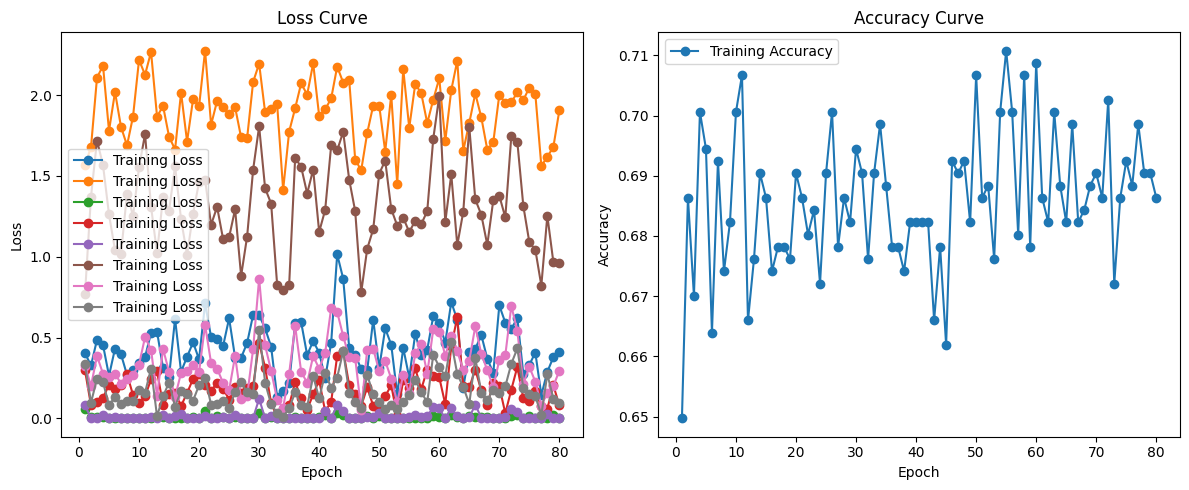

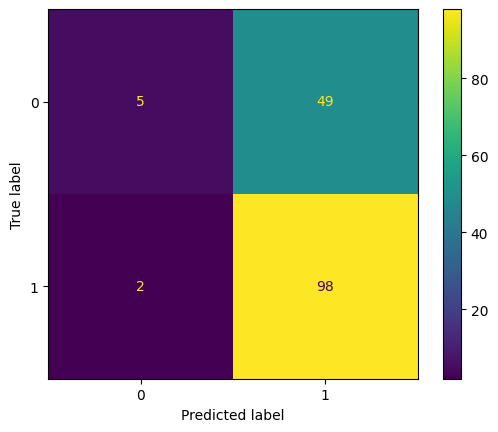

Sensitivity = 0.98
Specificity = 0.09259259259259259


In [ ]:
# Create a new Perceptron object with the best hyperparameters
best_perceptron = Perceptron(
    loss_function=best_hyperparameters['Loss Function'],
    learning_rate=best_hyperparameters['Learning Rate'],
    n_epochs=best_hyperparameters['Number of Epochs'],
    initial_weight_seed=best_hyperparameters['Initial Weight Seed'],
    bias=best_hyperparameters['Bias']
)

# Fit the best_perceptron on the entire training set (X_actual_train, y_actual_train)
best_perceptron.fit(X_actual_train, y_actual_train)

# Make predictions on the test set (X_test)
y_pred_test = [best_perceptron.predict(x) for x in X_test]

# Calculate accuracy on the test set
accuracy_test = np.mean(y_pred_test == y_test)
print("Accuracy of Best Perceptron Model on Test Set:", accuracy_test)
best_perceptron.plot_loss_and_accuracy_curves()


from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

confusion_mat = confusion_matrix(y_test, y_pred_test)
true_neg, false_pos, false_neg, true_pos = confusion_mat.ravel()

sensitivity = true_pos / (true_pos + false_neg)
specificity = true_neg / (true_neg + false_pos)
balancedAccuracy = (sensitivity + specificity) / 2

# Plot conf matrix
confusion_diagram = ConfusionMatrixDisplay(confusion_mat)
confusion_diagram.plot() # 0 for diabetes and 1 for no diabetes
plt.show()

print("Sensitivity =", sensitivity)
print("Specificity =", specificity)

## Comparing with the performance of in-built Perceptron in sklearn

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

# Initialising in-built perceptron object from sklearn library
sklearn_perceptron = Perceptron(eta0=0.01, max_iter=40)

# training it on the training set
sklearn_perceptron_fit = sklearn_perceptron.fit(X_actual_train, y_actual_train)

# MAKING PREDICTIONS FOR THE TEST SET
predictions = sklearn_perceptron_fit.predict(X_test)

# getting the accuracy score for the above predictions
print("Test accuracy from in-built perceptron= ", accuracy_score(y_test, predictions))

Test accuracy from in-built perceptron=  0.7792207792207793


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
